# Homework 02 - Machine Learning for Regression

## Dataset

For this homework, we'll use the Car Fuel Efficiency dataset.


In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style("whitegrid")

In [4]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
df = pd.read_csv(url)
df.sample(3, random_state=42)


,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
483,220,3.0,144.0,2535.887591,18.7,2009,USA,Gasoline,All-wheel drive,2.0,16.642943
7506,160,2.0,141.0,2741.170484,14.3,2019,Asia,Diesel,Front-wheel drive,2.0,16.298377
8795,230,3.0,155.0,2471.880237,NaN,2017,Asia,Diesel,Front-wheel drive,2.0,18.591822


## Preparing the dataset

Use only the following columns:

    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'


In [5]:
cols = [
    "engine_displacement",
    "horsepower",
    "vehicle_weight",
    "model_year",
    "fuel_efficiency_mpg",
]

df = df.loc[:, cols]
df.sample(3, random_state=42)

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822


## EDA

- Look at the fuel_efficiency_mpg variable. Does it have a long tail?


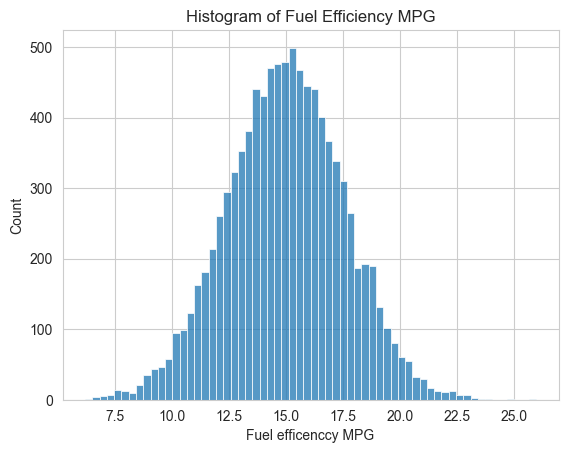

In [6]:
sns.histplot(data=df, x="fuel_efficiency_mpg")
plt.title("Histogram of Fuel Efficiency MPG")
plt.xlabel("Fuel efficenccy MPG")
plt.show()  # It has a bell-shaped distribution

## Question 1

There's one column with missing values. What is it?

    'engine_displacement'
    'horsepower'
    'vehicle_weight'
    'model_year'


In [7]:
(df.isnull().sum().reset_index(name="missing").query("missing > 0"))

,index,missing
1,horsepower,708


## Question 2

What's the median (50% percentile) for variable 'horsepower'?


In [8]:
print(f"The median (50% percentil) for horsepower is {df.horsepower.median()}")

The median (50% percentil) for horsepower is 149.0


## Prepare and split the dataset

    Shuffle the dataset (the filtered one you created above), use seed 42.
    Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures


In [9]:
# size of train/val/test sets
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

n == (n_train + n_test + n_val)

True

In [10]:
# shuffle the dataset and create the sets
idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]].copy()
df_val = df.iloc[idx[n_train : n_train + n_val]].copy()
df_test = df.iloc[idx[n_train + n_val :]].copy()

In [11]:
df_train.head(3)

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822


## Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?


In [12]:
target = "fuel_efficiency_mpg"
features = df.columns[df.columns != target].tolist()


def train_linear_regression(X, y):
    """
    Trains a linear regression model using the normal equation.
    """
    # Add a bias term (column of ones) to the feature matrix
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # Normal equation: w = (X^T * X)^-1 * X^T * y
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]


def rmse(y_true, y_pred):
    """
    Calculates the Root Mean Squared Error.
    """
    error = y_true - y_pred
    mse = (error**2).mean()
    return np.sqrt(mse)

In [13]:
# Filling missing horsepower with 0
X_train_zero = df_train[features].fillna(0).to_numpy()
y_train = df_train[target].to_numpy()

X_val_zero = df_val[features].fillna(0).to_numpy()
y_val = df_val[target].to_numpy()

# Train the model
w0_zero, w_zero = train_linear_regression(X_train_zero, y_train)

# Get predictions on the validation set
y_pred_zero = w0_zero + X_val_zero.dot(w_zero)

# Calculate and round the RMSE
rmse_zero = round(rmse(y_val, y_pred_zero), 2)

In [14]:
# Mean of horsepower from training data
horsepower_mean = df_train["horsepower"].mean()

# Filling missing values with the calculated mean
X_train_mean = df_train[features].fillna(horsepower_mean).to_numpy()
X_val_mean = df_val[features].fillna(horsepower_mean).to_numpy()

# Notice that y_train and y_val are the same as before

# Train the model
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

# Get predictions on the validation set
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)

# Calculate and round the RMSE
rmse_mean = round(rmse(y_val, y_pred_mean), 2)

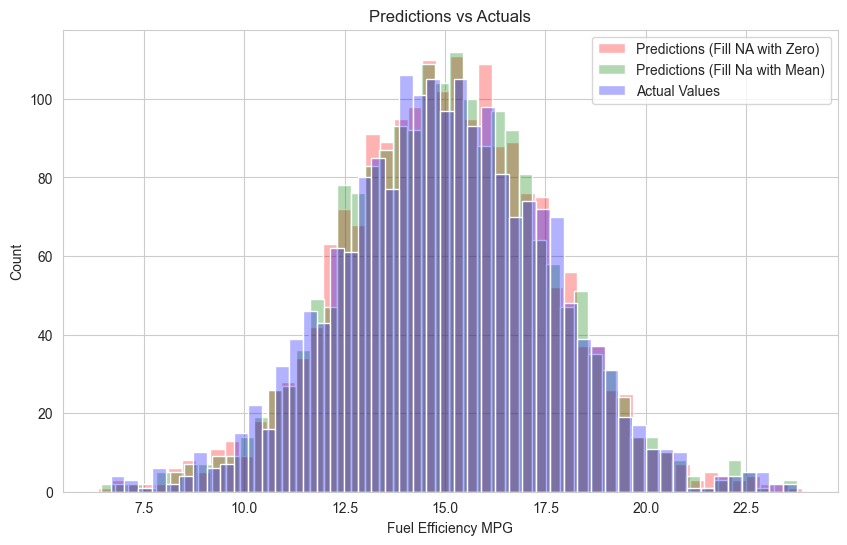

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_zero, color="red", alpha=0.3, bins=50)
sns.histplot(y_pred_mean, color="green", alpha=0.3, bins=50)
sns.histplot(y_val, color="blue", alpha=0.3, bins=50)
plt.title("Predictions vs Actuals")
plt.xlabel("Fuel Efficiency MPG")
plt.legend(
    [
        "Predictions (Fill NA with Zero)",
        "Predictions (Fill Na with Mean)",
        "Actual Values",
    ]
)
plt.show()


In [16]:
print(f"RMSE when filling missing values in horsepower with zero: {rmse_zero}")
print(f"RMSE when filling missing values in horsepower with mean: {rmse_mean}")

RMSE when filling missing values in horsepower with zero: 0.52
RMSE when filling missing values in horsepower with mean: 0.46


Filling the missing values with horsepower mean from the training set, gives a better RMSE


## Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?


In [17]:
def train_linear_regression_reg(X, y, r=0.0):
    """
    Trains a regularized linear regression model using the normal equation.
    """
    # Add a bias term (column of ones)
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # Normal equation with regularization: w = (X^T*X + r*I)^-1 * X^T*y
    XTX = X.T.dot(X)

    # Create the identity matrix for regularization
    reg = r * np.eye(XTX.shape[0])

    # Set the first element to 0 to not regularize the bias term
    # reg[0, 0] = 0

    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [18]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_scores = {}

for r in r_values:
    # Train the regularized model
    w0, w = train_linear_regression_reg(X_train_zero, y_train, r=r)

    # Make predictions on the validation set
    y_pred = w0 + X_val_zero.dot(w)

    # Calculate and round the RMSE
    score = round(rmse(y_val, y_pred), 2)

    # Store the result
    rmse_scores[r] = score

    print(f"r = {r:<4} | RMSE = {score}")


r = 0    | RMSE = 0.52
r = 0.01 | RMSE = 0.52
r = 0.1  | RMSE = 0.52
r = 1    | RMSE = 0.52
r = 5    | RMSE = 0.52
r = 10   | RMSE = 0.52
r = 100  | RMSE = 0.52


In [19]:
best_r = min(rmse_scores, key=rmse_scores.get)
best_rmse = rmse_scores[best_r]

print(f"The best RMSE is {best_rmse}, which is achieved with r = {best_r}.")


The best RMSE is 0.52, which is achieved with r = 0.


## Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))


In [20]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

for seed in seeds:
    # Set the seed for this iteration's data split
    np.random.seed(seed)

    # Shuffle the dataset indices
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.shuffle(idx)

    # Create the data splits
    df_train = df.iloc[idx[:n_train]].copy()
    df_val = df.iloc[idx[n_train : n_train + n_val]].copy()
    df_test = df.iloc[idx[n_train + n_val :]].copy()

    # Prepare data (fill missing values with 0)
    X_train = df_train[features].fillna(0).to_numpy()
    y_train = df_train[target].to_numpy()

    X_val = df_val[features].fillna(0).to_numpy()
    y_val = df_val[target].to_numpy()

    # Train the model (without regularization)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)

    # Calculate and store the score
    score = rmse(y_val, y_pred)
    rmse_scores.append(score)

    print(f"Seed: {seed} -> RMSE: {round(score, 3)}")


Seed: 0 -> RMSE: 0.521
Seed: 1 -> RMSE: 0.521
Seed: 2 -> RMSE: 0.523
Seed: 3 -> RMSE: 0.516
Seed: 4 -> RMSE: 0.511
Seed: 5 -> RMSE: 0.528
Seed: 6 -> RMSE: 0.531
Seed: 7 -> RMSE: 0.509
Seed: 8 -> RMSE: 0.515
Seed: 9 -> RMSE: 0.513


In [21]:
# Standard deviation of the scores
std_dev = round(np.std(rmse_scores), 5)
print(f"The standard deviation of the RMSE scores is: {std_dev}")

The standard deviation of the RMSE scores is: 0.00699


## Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?


In [22]:
# Set the seed
np.random.seed(seed)

# Split the data with 60%/20%/20% distribution
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.shuffle(idx)

# Create the data splits
df_train = df.iloc[idx[:n_train]].copy()
df_val = df.iloc[idx[n_train : n_train + n_val]].copy()
df_test = df.iloc[idx[n_train + n_val :]].copy()

# Combine train and validation datasets
df_train_val = pd.concat([df_train, df_val]).reset_index(drop=True)

In [23]:
# Prepare data (fill missing values with 0)
X_train_val = df_train_val[features].fillna(0).to_numpy()
y_train_val = df_train_val[target].to_numpy()

X_test = df_test[features].fillna(0).to_numpy()
y_test = df_test[target].to_numpy()

# Train the model with r=0.001
w0, w = train_linear_regression_reg(X_train_val, y_train_val, r=0.001)

# Make predictions on the test set
y_pred_test = w0 + X_test.dot(w)

# Calculate RMSE on the test set
rmse_test = round(rmse(y_test, y_pred_test), 4)

print(f"The RMSE on the test dataset is: {rmse_test}")

The RMSE on the test dataset is: 0.5156
